# Research
***
[Alejandro Ciuba](alejandrociuba.github.io), alc307@pitt.edu
***
## Summary
This is a continuation from the previous Jupyter Notebook (`overview.ipynb`) where I begin to analyze the data in-accordance to my proposed research questions. I might change or modify the research questions here. As such, I update both this and the main `README.md` file (not in `project_plan.md`, to retain the initial ideas for this research).
***
## Table of Contents
1. [Python Set-Up](#python-set-up)
2. [Orders & Requests](#how-are-ordersrequests-realized-in-video-game-dialogue)
3. [2nd Person Singular](#exploring-usage-of-the-2nd-person-pronoun)
4. [Other Pronouns](#other-pronouns)
5. [Entities](#named-entities)
6. [Hapaxes](#hapaxes)
***
## Python Set-Up

In [1]:
# Necessary imports
import nltk
import spacy
from spacy.matcher import Matcher

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import re

import pickle as pkl

### Settings

In [2]:
# Settings
# I looked this up so everything is prettier
from IPython.display import display, HTML

CSS = """
.output {
    flex-direction: row;
}
"""

HTML('<style>{}</style>'.format(CSS))

# Use display(dataframe) to show

%pprint

Pretty printing has been turned OFF


### Useful Functions

In [96]:
# Useful functions
# Makes a boxplot with my overall preferred settings
def barplot(x:list=[], y:list=[], title:str='NO TITLE', xlabel:str='x', ylabel:str='y', xtickrot:float=0.0):

    ax = sns.barplot(x=x, y=y)
    sns.set_style(style='dark')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=xtickrot)
    plt.bar_label(ax.containers[0])    

# Function such that it counts all instances of the given regular expression for each item in a dataframe's specified column
def locator(series: pd.Series, regex:re.Pattern) -> int:
    return np.sum([len(x) for x in series.str.findall(regex)])

# Returns text count 
def get_count(col:pd.Series) -> int:
    count = 0
    for text in col:
        count += len(nltk.word_tokenize(text))
    return count

# Generator which yields the concordances for a given textual column of a dataframe
# phrase should be a raw string, context cols should be a list of column names
# once_per = only one concordance per textual datapoint (if there is more)
# sides = # of chars to the left and right
# num = number of concordances to display, -1 for all
# Assumes properly formatted text
# If default is false, entire phrase will be treated as the concordance
# highlight will capitalize the find, recommended to turn off for custom regex
def concordances(df:pd.DataFrame, phrase:str or re.Pattern, col:str='text', context_cols: list()=[], sides:int=7, num:int=20, once_per=False, default=True, highlight=True):
    
    # Set-up
    context = bool(len(context_cols))
    regex = re.compile(r'((?:[\S]+ ){,' + str(sides) + r'})(\b' + phrase + r'\b)((?:[\S]+)?(?: [\S]+){,' + str(sides) + r'})', re.I) if default else phrase
    cutoff = 0

    for (ind, concordance_list) in enumerate(df[col].str.findall(regex)):

        if len(concordance_list) == 0:
            continue

        # Format text if context was stated
        output = ''
        if context:
            cont = df.loc[ind, context_cols]
            output = ' | '.join([col.title() + ": " + cont[col] for col in context_cols]) + " | Concordance:\n\t"

        for concordance in concordance_list:

            # Disgusting, I now. It gets the job done for now, but if I use this again, I will try to opt.
            if num != -1:
                cutoff += 1  
                if cutoff > num:
                    return

            if highlight:
                concordance = list(concordance) 
                concordance[1] = concordance[1].upper() # Do it separately due to edge case "your you" -> "YOUr YOU"

            yield output + '...' + ''.join(concordance) + '...'
                
            if once_per:
                break

### Data-Importing

In [4]:
# Bringing in the dataframes
FILEPATH = "../private/pickled_dfs/"

elder_scrolls_df = pd.read_pickle(FILEPATH + "elder_scrolls.pkl")
hollow_knight_df = pd.read_pickle(FILEPATH + "hollow_knight.pkl")
kotor_df = pd.read_pickle(FILEPATH + "kotor.pkl")
torchlight_df = pd.read_pickle(FILEPATH + "torchlight.pkl")

# All dfs stored in a simple list
datasets = [elder_scrolls_df, hollow_knight_df, kotor_df, torchlight_df]

### spaCy Set-Up

In [5]:
# Load the standard en_core_web transformer
nlp = spacy.load("en_core_web_trf")

In [6]:
# Create a stream dump of all the text from hollow_knight_df and torchlight_df, save them to two files in my private sub-directory
# Create random sample .txts from elder_scrolls_df and kotor_df, 1000000 is the max amount of tokens
# MADE FALSE TO PREVENT ACCIDENTAL FILE CREATION
if False:
    with open('../private/text_dumps/hollow_knight.txt', 'w') as src:
        for text in hollow_knight_df['text']:
            src.write(text)

    with open('../private/text_dumps/torchlight.txt', 'w') as src:
        for text in torchlight_df['text']:
            print(text)

    with open('../private/text_dumps/elder_scrolls_samp.txt', 'w') as src:
        for text in elder_scrolls_df['text'].sample(500):
            src.write(text)

    with open('../private/text_dumps/kotor_samp.txt', 'w') as src:
        for text in kotor_df['text'].sample(500):
            src.write(text)

In [7]:
# Create document objects from the texts
# MEMORY INTENSIVE!!!
if False:
    with open('../private/text_dumps/torchlight.txt', 'r') as src:
        torchlight_doc = nlp(src.read(-1))
    print(type(torchlight_doc), len(torchlight_doc))

    with open('../private/text_dumps/hollow_knight.txt', 'r') as src:
        hollow_knight_doc = nlp(src.read(-1))
    print(type(hollow_knight_doc), len(hollow_knight_doc))

    with open('../private/text_dumps/elder_scrolls_samp.txt', 'r') as src:
        elder_scrolls_doc = nlp(src.read(-1))
    print(type(elder_scrolls_doc), len(elder_scrolls_doc))

    with open('../private/text_dumps/kotor_samp.txt', 'r') as src:
        kotor_doc = nlp(src.read(-1))
    print(type(kotor_doc), len(kotor_doc))

    # A list of the docs, structured like the datasets list
    docs = [elder_scrolls_doc, hollow_knight_doc, kotor_doc, torchlight_doc]

In [8]:
# Let's pickle these for later use
if False:
    with open('../private/pickled_docs/docs.pkl', 'wb') as src:
        pkl.dump(docs, src, -1)

# Load the pickled list
if True:
    with open('../private/pickled_docs/docs.pkl', 'rb') as src:
        docs = pkl.load(src)
        elder_scrolls_doc = docs[0]
        hollow_knight_doc = docs[1]
        kotor_doc = docs[2]
        torchlight_doc = docs[3]

### Dictionary

In [9]:
# Zip them together in one dictionary, first index is the dataframe, the second is the doc object generated by spaCy
data = {game: [df, doc] for (game, df, doc) in zip(["TES Books", "Hollow Knight", "KOTOR", "Torchlight II"], datasets, docs)}

***
## How Are Orders/Requests Realized in Video Game Dialogue?
This is a very broad topic. To approach this topic, let's first consider common phrases which indicate orders and requests.
- Direct Orders:
    1. _Mand. Form_ 
    2. _Don't/Do not/Do Mand. Form X._ 
    3. _I/we order/demand/force/command (that) you X._ (Performative Speech Act) 
- Indirect Orders:
    1. _You /need to/have to/must/should X._
    2. _Your objective/goal/quest/task is X._ 
    3. _I/we need/want/require/desire you Y._ 
    4. _Let's/Let us X._ 
- Direct Requests:
    1. _Please X._ 
    2. _I/we request (that you)/ask (of you) X._ (Performative Speech Act) 
- Indirect Requests:
    1. _I/we would like (that) you Y._ 
    2. _May/Would/Can/Could you X?_ Can you can be both an indirect request or direct question, requires context.
    3. _Is it possible for you to X?_ Same as 2.
    4. _Are you able to X?_

This is obviously not an exhastive list, but it does cover the most common forms that orders and requests can take. Troublingly, I might miss indirect speech acts which disguise themselves as assertions (e.g. _"Your homework isn't done!_) because they are just too broad for me to capture. I will also miss sentences which require context such as tone and utterance-context (e.g. _"I'm not doing the report. You write it!_" vs. _"We'll make it big! You write it. I direct it. We'll be millionaires!"_).
 
**NOTE:** On top of these shortcomings, some speech acts I recognized had to be simplified due to complexity.

### Approach
A combination of regular expressions and _spaCy_'s _Matcher_, with its part of speech tagging ([est. 97% accuracy](https://spacy.io/usage/facts-figures#benchmarks)), will be used. While all of this can be done with only _spaCy_, the phrases which can be tagged through pure regular expressions will be more accurate overall.

There is some slight overlap between what the _Matcher_ expressions find and what the regex expressions find. That's okay, we can determine the exact type of order/request through context. Also note that I wasn't able to capture utterance context, so some false-positives will be present in these findings.
### Matcher Expressions
The ones I did through this were because either:
    
a) It was simply easier to think about using the Matcher's more dictionary-like style.
    
b) Morphological context was needed

In [45]:
# MATCHER EXPRESSIONS
matcher = Matcher(nlp.vocab)

DO1 = [{"IS_SENT_START": True, "MORPH": "VerbForm=Inf"},
    {"LOWER": {"REGEX": "[a-z]+"}, "OP": "+"},
    {"IS_PUNCT": True}]

DO3 = [{"LEMMA": {"IN": ["I", "we"]}}, 
    {"LEMMA": "be", "MORPH": {"IS_SUPERSET": ["Tense=Pres"]}, "OP":"?"}, 
    {"LOWER": {"REGEX": "^(order|force|demand|command)(ing)?$"}},
    {"LOWER": {"REGEX": "[a-z]+"}, "OP": "+"},
    {"IS_PUNCT": True}]

IO2 = [{"LOWER": "your"},
    {"LEMMA": {"IN": ["objective", "goal", "quest", "task", "mission", "target"]}},
    {"LEMMA": "be", "MORPH": {"IS_SUPERSET": ["Tense=Pres"]}},
    {"LOWER": {"REGEX": "[a-z]+"}, "OP": "+"},
    {"IS_PUNCT": True}]

IO3 = [{"LEMMA": {"IN": ["I", "we"]}},
    {"LEMMA": "be", "MORPH": {"IS_SUPERSET": ["Tense=Pres"]}, "OP":"?"}, 
    {"LOWER": {"REGEX": "^(need|want|require|desire|requir|desir)(ing)?$"}},
    {"LOWER": "that", "OP": "?"},
    {"LEMMA": "you"},
    {"LOWER": {"REGEX": "[a-z]+"}, "OP": "+"},
    {"IS_PUNCT": True}]

DR2 = [{"LEMMA": {"IN": ["I", "we"]}},
    {"LEMMA": "be", "MORPH": {"IS_SUPERSET": ["Tense=Pres"]}, "OP":"?"}, 
    {"LOWER": {"REGEX": "^(request|ask)(ing)?$"}},
    {"LOWER": {"REGEX": "^that|of$"}, "OP": "?"},
    {"LEMMA": "you"},
    {"LOWER": {"REGEX": "[a-z]+"}, "OP": "+"},
    {"IS_PUNCT": True}]

# Add them to the matcher and classify them
matcher.add("DIRECT ORDERS", [DO1, DO3,], greedy="LONGEST")
matcher.add("INDIRECT ORDERS", [IO2, IO3], greedy="LONGEST")
matcher.add("DIRECT REQUESTS", [DR2], greedy="LONGEST")

### Regular Expressions
These were the "copy and paste" ones, so-to-speak. These relied less on linguistical features, and most are divided into "chunks." Mainly, most contain a "Header" section consisting of either a simple `\b` word boundary, or a more complicated look-ahead section because they _specifically_ needed to start the beginning of a sentence/independent clause to correctly capture them. The next section is simply what I am looking for, the body. And lastly, the foot contains what would be the rest of the sentence. I want to capture this too, so it is not in a lookbehind section (not that I could do that anyway since both "looks" require a fixed length). The main thing that changes here is what punctuation I am looking for at the end.

In [46]:
# REGULAR EXPRESSIONS
DO2 = re.compile(r'(?<=[\.!\?,;:]\s)Do(?: not|n\'t(?: you)?)? (?:[^\.!\?]+)?[\.!]', re.I)

IO1 = re.compile(r'\byou (?:really )?(?:(?:need to)|(?:have to)|must|should)(?:[^\.!\?]+)?[\.!]', re.I)
IO4 = re.compile(r'(?<=[\.!\?,;:]\s)Let(?:\'s| us)(?:[^\.!\?]+)?[\.!]', re.I)

DR1 = re.compile(r'(?<=[\.!\?]\s)Please(?:[^\.!\?]+)?[\.!\?]', re.I)

IR1 = re.compile(r'\b(?:I|we) would like(?: that)? you(?:[^\.!\?]+)[\.!]', re.I)
IR2 = re.compile(r'\b(?:May|Would|Can|Could) you(?:[^\.!\?]+)?[\.!\?]', re.I)
IR3 = re.compile(r'\bIs it possible for you to(?:[^\?]+)?\?', re.I)
IR4 = re.compile(r'(\bAre you able to(?:[^\?]+)?\?)', re.I)

# Toss them all into a nice little dict and call it a day :)
ord_req = {"DO2": DO2, "IO1": IO1, "IO4": IO4, "DR1": DR1, "IR1": IR1, "IR2": IR2, "IR3": IR3, "IR4": IR4}

Now let's use these to examine some orders and requests. Let's start by looking at the orders and requests using the simple `re` regex, since a lot of context can still be observed by observing the rest of the Dataframe. I'll tackle this in a few stages, first I'll compile a list of orders and requests and observe what we see. Then, I'll try to graph the numbers of order and request types found per video game. Although, again, the regular expressions might produce false negatives and positives, so these numbers will be slightly off. I might try to formalize the precision and recall rates later, but probably not.

In [53]:
# Iterate through our little dictionary, getting some samples of these from our games
# We're going to write this data to a textfile since even displaying only 5 instances of each
# Would still yield 8 * 5 * 4 = 160 results, way too much for this notebook.
# However, a very very small sample of some will be outputted here in the notebook for display.
# I did separate for-loops for each section because the context cols are different
with open('orders_requests.txt', 'w') as src:

    src.write("=============== ORDER AND REQUESTS FOR KOTOR ===============\n")
    for regex in ord_req:
        src.write('\n\t' + regex + '\n')
        for text in concordances(kotor_df, ord_req[regex], context_cols=['speaker'], num=10, default=False, highlight=False):
            src.write(text + '\n')

    src.write("\n=============== ORDER AND REQUESTS FOR HOLLOW KNIGHT ===============\n")
    for regex in ord_req:
        src.write('\n\t' + regex + '\n')
        for text in concordances(hollow_knight_df, ord_req[regex], context_cols=['character'], num=10, default=False, highlight=False):
            src.write(text + '\n')

    src.write("\n=============== ORDER AND REQUESTS FOR TORCHLIGHT II ===============\n")
    for regex in ord_req:
        src.write('\n\t' + regex + '\n')
        for text in concordances(torchlight_df, ord_req[regex], context_cols=['speaker'], num=10, default=False, highlight=False):
            src.write(text + '\n')

    src.write("\n=============== ORDER AND REQUESTS FOR THE ELDER SCROLLS ===============\n")
    for regex in ord_req:
        src.write('\n\t' + regex + '\n')
        for text in concordances(elder_scrolls_df, ord_req[regex], context_cols=['author', 'title'], num=10, default=False, highlight=False):
            src.write(text + '\n')

In [97]:
print("=============== ORDER AND REQUESTS FOR KOTOR ===============\n")
for regex in ord_req:
    print('\t' + regex)
    for text in concordances(kotor_df, ord_req[regex], context_cols=['speaker'], num=1, default=False, highlight=False):
        print(text)

print("=============== ORDER AND REQUESTS FOR HOLLOW KNIGHT ===============\n")
for regex in ord_req:
    print('\t' + regex)
    for text in concordances(hollow_knight_df, ord_req[regex], context_cols=['character'], num=1, default=False, highlight=False):
        print(text)

print("=============== ORDER AND REQUESTS FOR TORCHLIGHT II ===============\n")
for regex in ord_req:
    print('\t' + regex)
    for text in concordances(torchlight_df, ord_req[regex], context_cols=['speaker'], num=1, default=False, highlight=False):
        print(text)

print("=============== ORDER AND REQUESTS FOR THE ELDER SCROLLS ===============\n")
for regex in ord_req:
    print('\t' + regex)
    for text in concordances(elder_scrolls_df, ord_req[regex], context_cols=['author', 'title'], num=1, default=False, highlight=False):
        print(text)

=============== ORDER AND REQUESTS FOR KOTOR ===============

	DO2
Speaker: Elora | Concordance:
	...Don't insult us both!...
	IO1
Speaker: Elora | Concordance:
	...You must find Sunry innocent!...
	IO4
Speaker: Jolee | Concordance:
	...Let's not forget that he would have had to have been considerably older than the Sith woman....
	DR1
Speaker: Elora | Concordance:
	...Please, I must speak to him....
	IR1
	IR2
Speaker: Player | Concordance:
	...Can you tell me anything about Sunry?...
	IR3
Speaker: Bastila | Concordance:
	...Is it possible for you to keep in mind that we have more pressing business to attend to?...
	IR4
Speaker: Player | Concordance:
	...are you able to speak with the Sand People when I can't?...
=============== ORDER AND REQUESTS FOR HOLLOW KNIGHT ===============

	DO2
Character: Leg Eater | Concordance:
	...Don't try to trick me....
	IO1
Character: Confessor Jiji | Concordance:
	...you must need my help....
	IO4
Character: Iselda | Concordance:
	...let's see what's h

In [182]:
# Now for the hard part... graphing them. Hard because it'll be hard to make the graph look pretty :\
# Let's make a dataframe to keep track of everything
# Also... essentially quadruple for-loop. What? Sue me!

ordreq_df = pd.DataFrame({'speech_act':[], 'count':[], 'game': []})

for regex in ord_req:
    for game in data:
        ordreq_df = ordreq_df.append({'speech_act': regex, 
        'count': len(list(concordances(data[game][0], ord_req[regex], num=-1, default=False))), 
        'game': game}, ignore_index=True)

display(ordreq_df)

# And .pkl for the /sample_data directory
if False: ordreq_df.to_pickle('../sample_data/ordreq.pkl')

,speech_act,count,game
0,DO2,548.0,TES Books
1,DO2,41.0,Hollow Knight
2,DO2,310.0,KOTOR
3,DO2,2.0,Torchlight II
4,IO1,550.0,TES Books
5,IO1,36.0,Hollow Knight
6,IO1,635.0,KOTOR
7,IO1,43.0,Torchlight II
8,IO4,90.0,TES Books
9,IO4,11.0,Hollow Knight


<AxesSubplot:title={'center':'Speech Acts per Video Game'}, xlabel='Speech Act', ylabel='Count'>

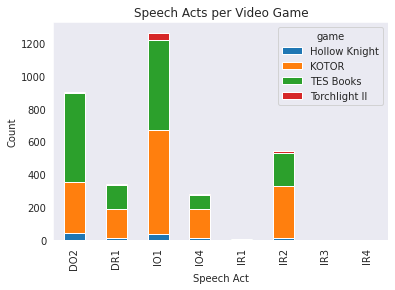

In [193]:
info = ordreq_df.groupby('speech_act').game.value_counts()

# This is really disgusting, but oh well...
for outer, inner in info.index:
    info[outer][inner] = ordreq_df[(ordreq_df['speech_act'] == outer) & (ordreq_df['game'] == inner)]['count']

info.unstack().plot.bar(stacked = True, xlabel='Speech Act', ylabel='Count', title='Speech Acts per Video Game')

***
## Exploring Usage of the 2nd Person Pronoun
First, focusing on _you_ (not "you-you", but _you_, the word), let's simply graph the number of occurrences in each of the datasets. To do this, we must consider what forms of you could appear in the dataset. Obviously, the biggest concerns would be contractions (_you're_, _you'd_), but what about _y'all_? Since _y'all_ can refer **both** to an individual and a group of people, I chose to ignore it for two reasons:
1. I want to focus on the 2nd person **singular** pronoun to see how it is used in relation to the player.
2. Overall occurrences of _y'all_ are low, and the times they refer directly to the player is even lower; this means we can ignore it without the concern of data-skewing.

Previously, I have created a function which, given a compiled regular expression, will find all instances of that regular expression for each textual item in a dataframe's column. And below, I have compiled a relatively simple regex to capture all the _you_ instances I am after. I then plot the number of _you_ occurrences for each dataset.

In [12]:
you_re = re.compile(r"\byou\b", re.I)

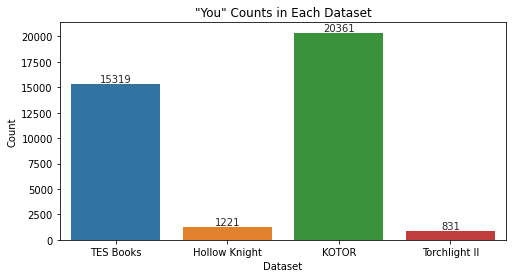

In [13]:
counts = np.array([])

for df in datasets:
    counts = np.append(counts, locator(df['text'], you_re))

plt.figure(figsize=(8,4))
barplot(x=list(data.keys()), y=counts, title='"You" Counts in Each Dataset', xlabel="Dataset", ylabel="Count")
plt.show()

In [14]:
# Hollowknight suffers from some slight inaccuracies due to its tagging system
percentages = counts / [get_count(df['text']) for df in datasets]

print(percentages)

[0.00799316 0.02830189 0.03653764 0.02430749]


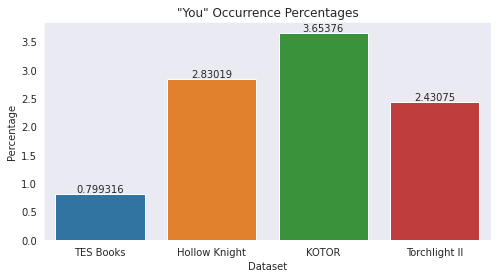

In [15]:
plt.figure(figsize=(8,4))
barplot(x=list(data.keys()), y=percentages*100, title='"You" Occurrence Percentages', xlabel="Dataset", ylabel="Percentage")
plt.show()

This makes sense given that the data for _Hollow Knight_, _KOTOR_, and _Torchlight_ all relate to directing the player and giving the players objectives/quests in some way, shape, or form. The dataset pertaining to _The Elder Scrolls_ however, does not. Since its dataset is that of books written to be read by the player in-game, it makes sense that there is an extremely low frequency of the 2nd person pronoun. I expect this to change with other pronouns.

Let's take a look at some of the contexts which the second person singular takes place in.

In [16]:
print("===================== \"You\" Concordance Samples =====================")
print("===================== TES Books =====================")
for sent in concordances(elder_scrolls_df.sample(100, ignore_index=True), phrase='you', context_cols=['author', 'title'], num=10, once_per=True):
    print(sent)

print("===================== Hollow Knight Dialogue =====================")
for sent in concordances(hollow_knight_df.sample(10, ignore_index=True), phrase='you', context_cols=['character'], num=10, once_per=True):
    print(sent)

print("===================== KOTOR Dialogue =====================")
for sent in concordances(kotor_df.sample(100, ignore_index=True), phrase='you', context_cols=['speaker', 'listener'],num=10, once_per=True):
    print(sent)

print("===================== Torchlight Quests =====================")
for sent in concordances(torchlight_df.sample(100, ignore_index=True), phrase='you', context_cols=['speaker'], num=10, once_per=True):
    print(sent)

===================== "You" Concordance Samples =====================
===================== TES Books =====================
Author: Adan Kordrel | Title: citizens-petition | Concordance:
	...been done. It is bad enough that YOU permit a black market to operate so...
Author: K | Title: oblans-letter | Concordance:
	...Your captain's patriotic foolishness has drawn YOU the best possible assignment! Imagine, "scouting" for...
Author: Atheneum Monks at Old Anthel | Title: song-askelde-men | Concordance:
	...YOU sped them to glory, Hail Spirit Wulfharth"...
Author: N | Title: burnt-note | Concordance:
	...laid upon Ayrenn herself. As we agreed, YOU will be named Canonreeve of Skywatch in...
Author: Anonymous | Title: story-princess-eselde | Concordance:
	...disfigured by unsightly warts. "By some oversight YOU failed to invite me to your daughter's...
Author: Deldrise Morvayn | Title: truth-sequence-volume-5 | Concordance:
	..."But, was Dumac not a creator?" YOU ask? "Were the brass-child's

***
## Other Pronouns
Let's at the percentages for some other common pronouns: _I/me_, _he/she/him/her_, _we/us_, _they/them_. The reason I chose to go with these forms is because these forms can appear in the same contexts that _you_ would appear in. In other words, I'm simply leaving out posessive pronouns. Of course, just like with _you_, I have to consider some contractions, but those have been treated the same way as before.

In [17]:
# List of regexes
fp_re = re.compile(r"\b(?:I|me)\b") # Had to ignore case for this one
tp_re = re.compile(r"\b(?:(?:s)?he|(?:h)(?:er|im))\b", re.I)
fpp_re = re.compile(r"\b(?:we|us)\b", re.I)
tpp_re = re.compile(r"\bthe(?:y|m)\b", re.I)

re_dict = {"First Person Singular": fp_re, "Third Person Singular": tp_re, "First Person Plural": fpp_re, "Third Person Plural": tpp_re}

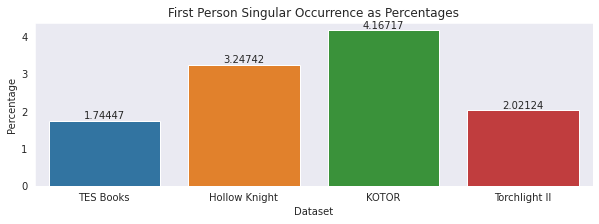

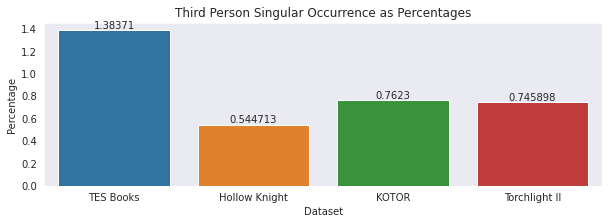

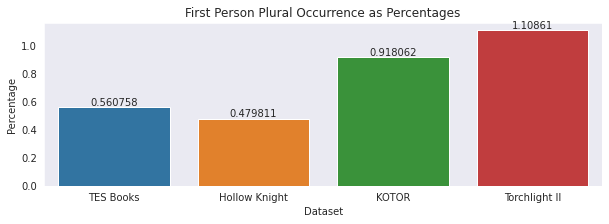

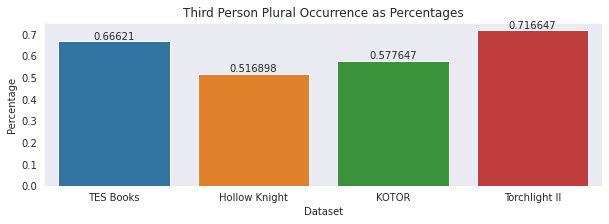

In [18]:
# Loop through everything
for pronoun in re_dict.keys():

    percentages = np.array([])

    plt.figure(figsize=(10, 3))

    for df in datasets:
        percentages = np.append(percentages, locator(df['text'], re_dict[pronoun])/get_count(df['text']))

    barplot(x=list(data.keys()), y=percentages*100, title=pronoun + ' Occurrence as Percentages', xlabel="Dataset", ylabel="Percentage")

plt.show()

***
## Named Entities
For this, I will be using _spaCy_ and its standard _"en\_core\_web\_trf"_ model. While it is an AI model, its named-entity tagger accuracy is [estimated to be around 90%](https://spacy.io/usage/facts-figures#benchmarks). I will also be taking only samples of `kotor_df` and `elder_scrolls_df` as their full texts are too big to be loaded onto one _spaCy_ model. Additionally, these models will base themselves off of the pure text of the dataframes, with no additional information. This is because, due to the fact I will be relying on named entity recognition, other data (author, character, listener, etc.) might (will) be mistaken as a named entity in the sentences. Furthermore, I am only interested in the named entities in the texts themselves, not outside sources.

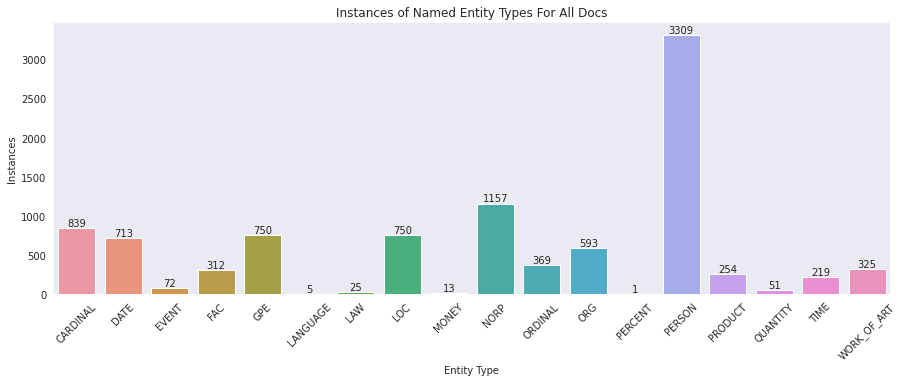

In [19]:
# Let's create a dictionary to keep track of the named-entity types we see
entities = {label: 0 for label in nlp.get_pipe('ner').labels}

for doc in docs:
    for ent in doc.ents:
        entities[ent.label_] += 1

plt.figure(figsize=(15,5))
barplot(x=list(entities.keys()), y=list(entities.values()), title="Instances of Named Entity Types For All Docs", xlabel="Entity Type", ylabel="Instances", xtickrot=45)

Let's create a dataframe which will contain the following information:

| Column | Data |
| ------ | ---- |
| `entity` | Name of the entity |
| `tag` | Entity Tag as given by _spaCy_ |
| `source` | Game from which it came |

This will be useful for graphing more detailed charts as well as exploring hapaxes.

In [20]:
# Dataframe creation
entities_df = pd.DataFrame({'entity':[], 'tag': [], 'source': []})
names = ['TES Books', 'Hollow Knight', 'KOTOR', 'Torchlight II']

# Loop through all the documents
for (doc, name) in zip(docs, names):
    for ent in doc.ents:
        entities_df = entities_df.append({'entity': ent.text, 'tag': ent.label_, 'source': name}, ignore_index=True)

In [21]:
print(entities_df.info())
display(entities_df.sample(10))
if False: entities_df.to_pickle('../sample_data/entities.pkl') # Save a .pkl for others to use

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9757 entries, 0 to 9756
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   entity  9757 non-null   object
 1   tag     9757 non-null   object
 2   source  9757 non-null   object
dtypes: object(3)
memory usage: 228.8+ KB
None


,entity,tag,source
1419,Selenwe,PERSON,TES Books
2610,Argonian,NORP,TES Books
3110,Outlaw,PERSON,TES Books
4230,Veloth,PERSON,TES Books
1064,Feyfolken,PERSON,TES Books
3529,Mistwatch,LOC,TES Books
5356,the Mages Guild,ORG,TES Books
1010,the Temple of Auri-El's Bulletin,WORK_OF_ART,TES Books
7134,Geo,PRODUCT,Hollow Knight
9599,Zeryphesh,GPE,Torchlight II


Something interesting to note is that it lumps holidays/festivals (_Witches' Festival_, _Jester's Day_, etc.) into `ORG` (organizations) and [there is not a specific tag for holidays/festivals](https://spacy.io/api/annotation). There's also some mistakes (_Day_ being called a `PERSON`), but I will assume the errors are small and continue.

In [22]:
# Let's get some of the lower value counts: LANGUAGE, MONEY, and PERCENT
display(entities_df[(entities_df['tag'] == 'LANGUAGE') | (entities_df['tag'] == 'MONEY') | (entities_df['tag'] == 'PERCENT')].sample(15))

,entity,tag,source
3881,a few hundred gold pieces,MONEY,TES Books
6616,Ten percent,PERCENT,TES Books
3222,twenty five thousand gold pieces,MONEY,TES Books
8114,100 credits,MONEY,KOTOR
822,Jel,LANGUAGE,TES Books
3218,twenty five thousand gold pieces,MONEY,TES Books
5204,"10,000 (ten thousand)",MONEY,TES Books
4188,10 coins,MONEY,TES Books
3200,thirty million gold pieces,MONEY,TES Books
4414,Daedric,LANGUAGE,TES Books


Let's look at the word _"Cyrodiilic"_ in context.

In [23]:
for text in concordances(elder_scrolls_df, phrase=r'Cyrodiilic', col='text', context_cols=['author', 'title'], sides=40):
    print(text)

Author: Anonymous | Title: monomyth-cyrodiilic-shezarrs-song | Concordance:
	...Note: This part was known as the CYRODIILIC Creation Myth....
Author: Waughin Jarth | Title: wolf-queen-v1 | Concordance:
	...The documents were well organized by year, province, and kingdom, and it took Potema only a short while to find the Promise of Marriage between Uriel Septim II, by the Grace of the Gods, Emperor of the Holy CYRODIILIC Empire of Tamriel and his daughter the Princess Galana, and His Majesty King Mantiarco of Solitude. She grabbed her prize and was out of the Hall with the door well-locked before the page was even in sight....
Author: Rallaume Lemonds, Culinary Crusader | Title: culinary-adventure-volume-2 | Concordance:
	...small reed enclosures that each house hundreds of caterpillars. I was shocked by the sheer variety. I saw long caterpillars, fat caterpillars, orange and purple-striped caterpillars—I've never seen such diversity! I asked a few questions, but Mach-Makka's limited ma

In [24]:
# Graph entities by type and game
# Creat stacked Series
entities_info = entities_df.groupby('tag').source.value_counts() # Never understood why this is a Series.

# Replace 'NaN's with 0
display(entities_info.unstack(fill_value=0)) # Wow

source,Hollow Knight,KOTOR,TES Books,Torchlight II
tag,,,,
CARDINAL,136,10,627,66
DATE,10,10,644,49
EVENT,2,1,66,3
FAC,40,11,156,105
GPE,58,13,578,101
LANGUAGE,0,1,4,0
LAW,1,2,22,0
LOC,40,9,427,274
MONEY,1,2,10,0


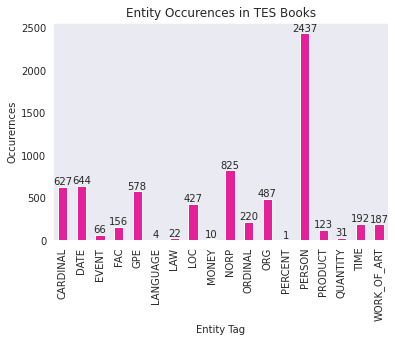

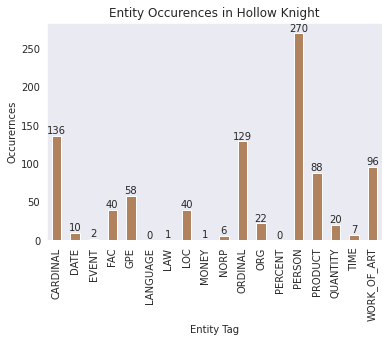

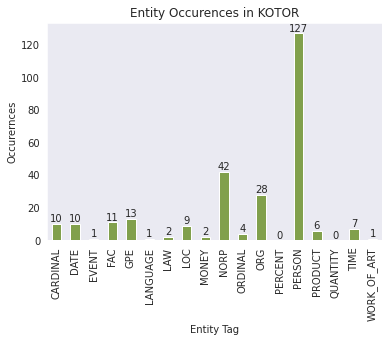

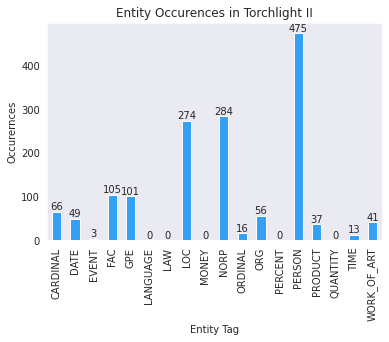

In [25]:
# Now let's actually graph it!
# Graph for all games
for game in names:
    ax = entities_info.unstack().plot.bar(stacked=True, y=game, xlabel='Entity Tag', ylabel='Occurernces'
                                        , legend=False, title='Entity Occurences in ' + game, color=np.random.rand(3), rot=90)
    plt.bar_label(ax.containers[0])

These aren't the prettiest, but they do accurately highlight the proportion of named entity types per video game. The most common named entity, by far, seems to be `PERSON` for all games, followed by `NORP` in most cases.

**NOTE:** When I used the `en_core_web_sm` model, the most popular tag was an unrivaled `ORG` for all games, followed by `PERSON`. An interesting change and I believe this new data is more accurate.
***
## Hapaxes
This is a relatively simple task, let's get straight to it!

In [26]:
# Let's take our entity dataframe and filter for hapaxes by series
# Pretty ugly, but I couldn't think of a better way :\
hapaxes_tes = entities_df[entities_df['source'] == 'TES Books'].entity.value_counts()
hapaxes_tes = hapaxes_tes[hapaxes_tes == 1]
display(hapaxes_tes.sample(10))

# Extra filtering in Hollowknight due to tagging issues
# HOLLOW KNIGHT SEEMS TO CONTAIN NO HAPAXES!!!
"""hapaxes_hk = entities_df[~entities_df['entity'].str.contains('<', regex=False) & entities_df['source'] == 'Hollow Knight'].entity.value_counts()
hapaxes_hk = hapaxes_hk[hapaxes_hk == 1]
display(hapaxes_hk.sample())"""

hapaxes_hk = pd.Series()

hapaxes_tl = entities_df[entities_df['source'] == 'Torchlight II'].entity.value_counts()
hapaxes_tl = hapaxes_tl[hapaxes_tl == 1]
display(hapaxes_tl.sample(10))

hapaxes_ktr = entities_df[entities_df['source'] == 'KOTOR'].entity.value_counts()
hapaxes_ktr = hapaxes_ktr[hapaxes_ktr == 1]
display(hapaxes_ktr.sample(10))

hapaxes = [hapaxes_tes, hapaxes_hk, hapaxes_tl, hapaxes_ktr]

Umutha                     1
Horny                      1
Dwemeri                    1
Sun-in-Shadow              1
six years old              1
A Silver Dawn's            1
Old Bretic                 1
On Artaeum                 1
the Merchants' Festival    1
those 2 years              1
Name: entity, dtype: int64

/tmp/ipykernel_25941/1909425776.py:13: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  hapaxes_hk = pd.Series()


the Bone Gallery        1
Crown                   1
Cameron                 1
the Blight Bogs         1
Shah                    1
The Ezrohir Marauder    1
Journal                 1
the Nether Realm        1
Sammay                  1
Trillbot 4000.Oh        1
Name: entity, dtype: int64

Deadeye Duncan!I      1
Shasa                 1
every night           1
K-X12d                1
twelve                1
Czerka Corporation    1
second                1
tonight               1
Vorn                  1
the Dark Lord         1
Name: entity, dtype: int64

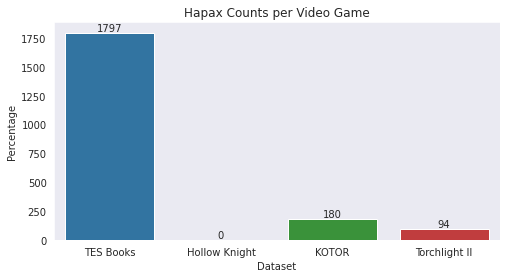

In [27]:
plt.figure(figsize=(8,4))
barplot(x=list(data.keys()), y=[len(series) for series in hapaxes], title='Hapax Counts per Video Game', xlabel="Dataset", ylabel="Percentage")
plt.show()

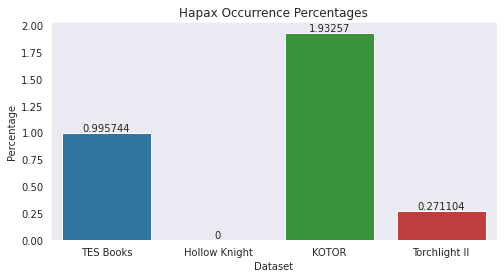

In [28]:
plt.figure(figsize=(8,4))
barplot(x=list(data.keys()), y=[len(series)/len(docs[ind]) * 100 for (ind, series) in enumerate(hapaxes)]
        , title='Hapax Occurrence Percentages', xlabel="Dataset", ylabel="Percentage")
plt.show()

These results surprise me as I was expecting _TES Books_ to contain the most hapaxes. However, something I think I forgot to account for was that, while _The Elder Scrolls_ uses a lot of made-up vocabulary directly related to its world, it uses those terms frequently. We also have to consider the fact that both _TES Books_ and _KOTOR_ are samples, not the full texts. Therefore, there might be more instances than what the model stated. An example of this is seen in the following code.

In [29]:
print("Hutt" in hapaxes_ktr.keys())
for text in concordances(kotor_df, phrase="Hutt", col='text', num=5):
    print(text)

True
...not a recognized circuit track. Motta the HUTT is not a respected promotor, no matter...
...hear that other tracks are falling under HUTT control....
...just go speak to Ajuur. He's that HUTT over in the corner. He'll make all...
...You here for money? I'll pay the HUTT what I owe as soon as the...
...me. Never get your bike fixed in HUTT Space....
